In [ ]:
import networkx as nx
import pandas as pd
from community import community_louvain
import json
import pprint
import matplotlib.pyplot as plt


In [ ]:
def undirected(year):
    G=nx.Graph()
    df=pd.read_csv(f"graphs/{year}.csv")
    for index, row in df.iterrows():
        source=row["source"]
        target=row["target"]
        weight=float(row[f"{year}"])
        if G.has_edge(row["source"],row["target"]):
            G[source][target]['weight']+=weight
        else:

            G.add_edge(source,target,weight=weight)

    return G



In [ ]:
G=undirected(2016)
print(list(G.nodes()))

In [ ]:
x=nx.adjacency_matrix(G)

In [ ]:
G.nodes()

In [ ]:
import networkx as nx
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Create a weighted graph (replace this with your weighted graph)
# G = nx.Graph()
# G.add_weighted_edges_from([(1, 2, 0.5), (1, 3, 0.8), (2, 3, 0.6), (3, 4, 0.7), (4, 5, 0.9)])

# Convert the graph to a distance matrix
distances = nx.to_numpy_array(G)

# Perform hierarchical clustering
linkage_matrix = sch.linkage(distances, method='ward')  # Ward's linkage method

# Plot the dendrogram
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(linkage_matrix, labels=list(G.nodes()), leaf_rotation=270)
plt.title('Dendrogram of Hierarchical Clustering')
plt.xlabel('Nodes')
plt.ylabel('Distance')
plt.show()


In [ ]:
partition = community_louvain.best_partition(G, weight='weight')

In [ ]:
def clustering(G):
    partition = community_louvain.best_partition(G, weight='weight')
    cluster={}
    for k,v in partition.items():
        if v not in cluster:
            cluster[v]=[k]
        else:
            cluster[v].append(k)

    return partition,cluster

    


In [ ]:
def draw_clusters(G, partition,year):
    # pos = nx.kamada_kawai_layout(G)  # Positions for all nodes
    pos = nx.spring_layout(G, k=5, iterations=50)
    plt.figure(figsize=(20, 20))
    # Draw nodes, colored by cluster
    for cluster_id in set(partition.values()):
        nodes = [node for node, c in partition.items() if c == cluster_id]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=plt.cm.jet(float(cluster_id) / len(set(partition.values()))), node_size=50, alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

    plt.axis("off")
    plt.savefig(f"cluster_images/{year}")


In [ ]:
def sum_edge_weights(G):
    total_weight = sum(weight for _, _, weight in G.edges(data='weight', default=1))
    return total_weight


In [29]:
cluster_strength={}
for i in range(2000,2022):
    G=undirected(i)
    partition,clusters=clustering(G)
    cluster_strength[i]=[]
    for key in clusters.keys():
        ratio=find_ratio(clusters[key])
        # cluster_strength[i][0].append(clusters[key])
        # cluster_strength[i][1].append(ratio)
        cluster_strength[i].append([clusters[key],ratio])


    # draw_clusters(G,partition,i)
    

    
    

In [32]:
def find_clus(country,year):
    for clus in cluster_strength[year]:
        for count in clus[0]:
            if country==count:
                return clus[1]


In [52]:
def find(color):
    if color=='red':
        return "US cluster"
    
    if color=='blue':
        return "Germany cluster"

    if color=='green':
        return "China cluster"

    if color=='brown':
        return "Russia cluster"

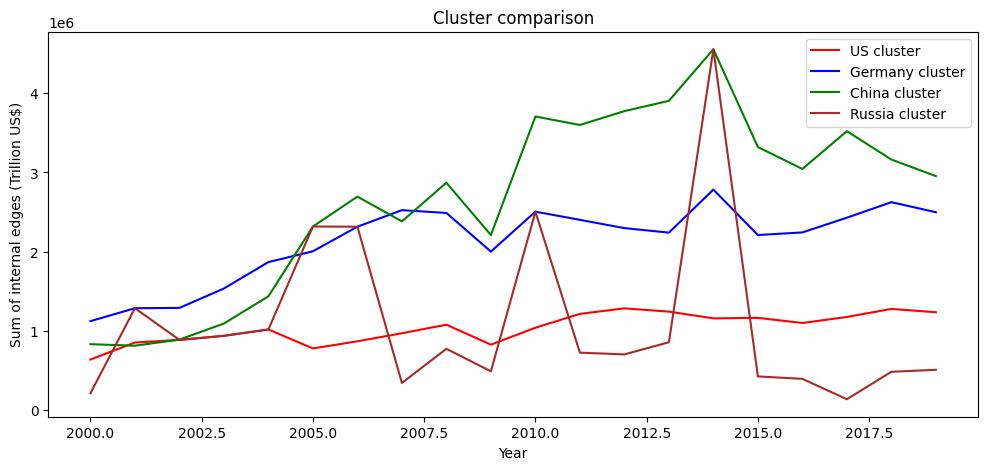

In [56]:
data_points={'red':[],'blue':[],'green':[],'brown':[],'violet':[]}

for i in range(2000,2020):
    clus1=find_clus("United States",i)
    clus2=find_clus("Germany",i)
    clus3=find_clus("China",i)
    clus4=find_clus("Russian Federation",i)
    # clus5=find_clus("India",i)
    
    data_points['red'].append((i, clus1,'United States cluster'))
    data_points['blue'].append((i, clus2,'Germany cluster'))
    data_points['green'].append((i, clus3,'China cluster'))
    data_points['brown'].append((i, clus4,'Russia cluster'))
    # data_points['violet'].append((i, clus5))

plt.figure(figsize=(12,5))
# Plot the data points and connect them with lines
for color, points in data_points.items():
    # Sort the data points based on year
    points.sort(key=lambda x: x[0])
    # count=(points[0][2])
    x_values = [point[0] for point in points]
    y_values = [point[1] for point in points]

    country=[point[2] for point in points]
    plt.plot(x_values, y_values, color=color,label=find(color))

# Add legend
plt.legend()
plt.xlabel("Year")
plt.ylabel("Sum of internal edges (Trillion US$)")
plt.title("Cluster comparison")
# Show plot
plt.savefig('cluster_images/graph')

In [ ]:
with open("clusters.txt","w") as fp:
    json.dump(cluster_strength,fp)

In [ ]:
with open("clusters.txt","w") as fp:
    for i in [2000,2004,2008,2012,2016,2020]:
        fp.write(i,"\n")
        for j in range(len(cluster_strength[i][1])):
            fp.write(cluster_strength[i][0][j],cluster_strength[i][1][j],"\n")
       

In [30]:
with open("clusters.log", "w") as log_file:
    pprint.pprint(cluster_strength,log_file)

In [ ]:
# print(cluster)
def find_ratio(cluster):
    subgraph=G.subgraph(cluster)
    int_edges=sum_edge_weights(subgraph)
    ext_set=nx.edge_boundary(G,subgraph)
    ext_edges=sum([float(G[u][v]['weight']) for u,v in ext_set])
    ratio=int_edges/ext_edges
    return int_edges


In [ ]:
communities_generator = nx.community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))